In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=69655dc12cd0765c826e43d07097de0fbf40c1c0a2e57e2b240bec397620a895
  Stored in directory: /root/.cache/pip/wheels/6f/ad/f4/4a269deab015672fd1ab353d6b2c3fcf64f413980737c13541
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8366 sha256=82ab0876011c5503717157a195bdd26a8d0d0bfbfcc541f0809e5a127499d6e6
  Stored in directory: /root/.cache/pip/wheels/5e/8a/c4/59c699498647c7c94b14c87a904ca7540646107b3d94b7c320
Successfully built yfinance multitasking


In [2]:
import tensorflow as tf
from tensorflow import keras

import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime

mpl.rcParams['figure.figsize'] = (16, 10)
mpl.rcParams['axes.grid'] = False

import plotly.offline as py
# That's line needed if you use jupyter notebook (.ipynb):
py.init_notebook_mode(connected=True)

import plotly.graph_objects as go

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [4]:
# Create candlestick chart to visualize Netflix (Symbol: NFLX) values across time from 5 years ago to present
tickerSymbol = 'NFLX'
today = datetime.date.today()
start = datetime.datetime(today.year-5,today.month,today.day)


def candleStick(symbol, startdate, enddate):
    tickerData = yf.Ticker(symbol)
    df = tickerData.history(period='1d', start=startdate, end=enddate)
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])

    fig.update_layout(
        title= {
            'text': symbol,
          'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
          font=dict(
            family="Times New Roman",
            size=20,
            color="#7f7f7f"
        )
        )

    fig.show()

In [5]:
candleStick(tickerSymbol, start, today)

# Preparing the data

In [6]:
def dataFrame(symbol, period, startdate, enddate):
    
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period=period, start=startdate, end=enddate)
    
    return tickerDf[columns]

df = dataFrame(tickerSymbol, '1d', start, today)

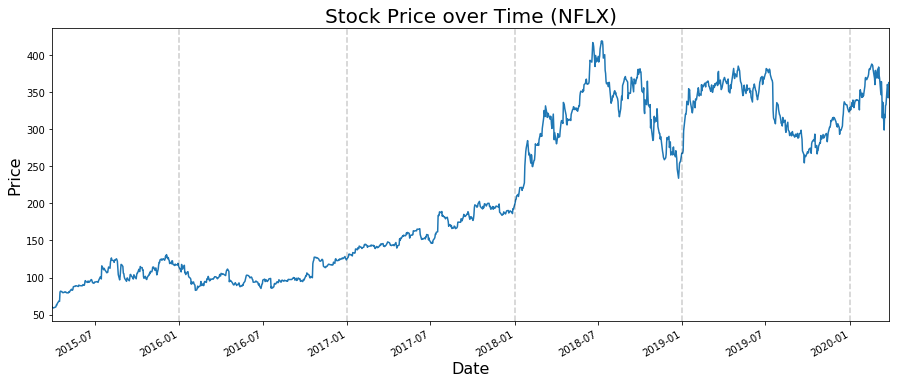

In [7]:
def plotChart(df):
    plt.figure(figsize=(15,6))
    df['Close'].plot()
    plt.title('Stock Price over Time (%s)'%tickerSymbol, fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    
    for year in range(2015,2021):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plotChart(df)

In [41]:
# Split dataset 80:20 train:test
# Print length of subsets
df1 = df[['Close']]

train_size = int(len(df1) * 0.8)
test_size = len(df1) - train_size

# Standarize dataset values to reduce loss
train_mean = df1[:train_size].mean()
train_std = df1[:train_size].std()

df1 = (df1-train_mean)/train_std

train, test = df1.iloc[0:train_size], df1.iloc[train_size:len(df1)]
print(len(train), len(test))

1007 252


In [42]:
# Values of training dataset now standardize
train

,Close
Date,
2015-03-30,-1.258336
2015-03-31,-1.266721
2015-04-01,-1.271812
2015-04-02,-1.270515
2015-04-06,-1.258735
...,...
2019-03-22,1.742780
2019-03-25,1.794888
2019-03-26,1.732398


In [43]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [44]:
# (samples, time_steps, features)
time_steps = 5

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(1002, 5, 1) (1002,)


# Building the model

In [69]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam

In [78]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer=Adam(0.001),loss='mean_squared_error')

In [46]:
# Build model with LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))

# Compile model
# loss with MSE
# Adam optimizer with 0.001 learning rate
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)               

In [80]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 901 samples, validate on 101 samples
Epoch 1/30
901/901 [==============================] - 3s 3ms/step - loss: 0.6467 - val_loss: 0.7602
Epoch 2/30
901/901 [==============================] - 1s 856us/step - loss: 0.2483 - val_loss: 0.4468
Epoch 3/30
901/901 [==============================] - 1s 870us/step - loss: 0.0866 - val_loss: 0.0350
Epoch 4/30
901/901 [==============================] - 1s 868us/step - loss: 0.0705 - val_loss: 0.0415
Epoch 5/30
901/901 [==============================] - 1s 866us/step - loss: 0.0449 - val_loss: 0.0601
Epoch 6/30
901/901 [==============================] - 1s 878us/step - loss: 0.0382 - val_loss: 0.0407
Epoch 7/30
901/901 [==============================] - 1s 868us/step - loss: 0.0353 - val_loss: 0.0407
Epoch 8/30
901/901 [==============================] - 1s 887us/step - loss: 0.0386 - val_loss: 0.0769
Epoch 9/30
901/901 [==============================] - 1s 879us/step - loss: 0.0341 - val_loss: 0.0887
Epoch 10/30
901/901 [=================

# Evaluating the model

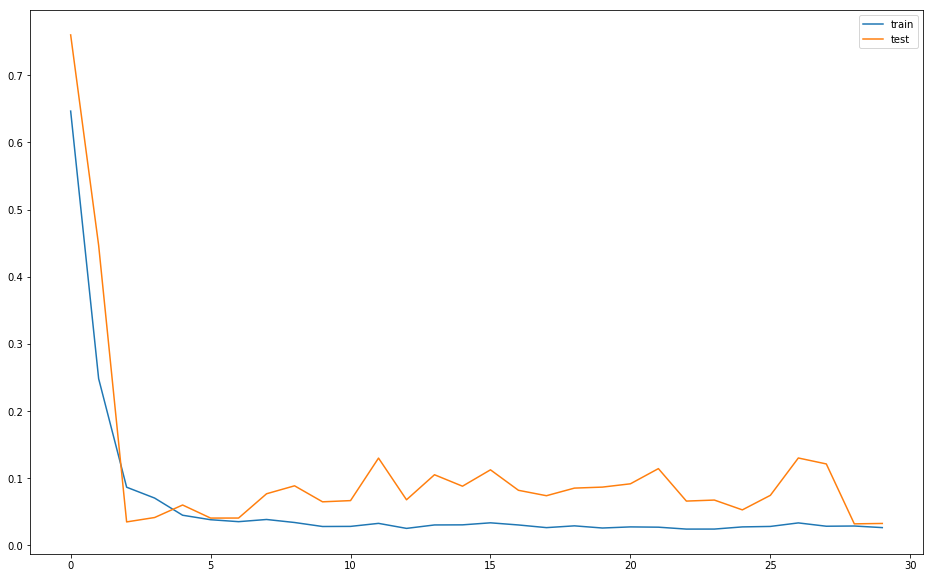

In [81]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [82]:
y_inv = (y_train*int(train_std))+int(train_mean)
y_inv

array([ 60.28619416,  62.84169482,  62.58215178, ..., 359.23984109,
       352.65144096, 353.88926159])

In [83]:
ytest_inv = (y_test*int(train_std))+int(train_mean)
ytest_inv

array([364.75013937, 360.6773102 , 363.97151027, 363.18289874,
       366.90634305, 350.42536031, 348.15934996, 358.73073744,
       354.01903311, 359.61917321, 376.57931233, 381.12131544,
       373.47477833, 367.58514791, 374.09368864, 371.07899646,
       369.79126371, 378.04672872, 378.29628933, 384.25579671,
       377.90697477, 369.71140432, 363.63210784, 362.01495508,
       360.3079605 , 344.55569474, 344.9050796 , 354.26859372,
       358.58100107, 353.7295428 , 347.40068571, 353.54985916,
       359.0002629 , 351.49347973, 353.66964825, 354.33847069,
       348.47878755, 351.13411245, 342.57917471, 335.94086246,
       352.68138823, 355.00729313, 356.40483255, 360.13825928,
       351.29383124, 350.55513183, 344.85516748, 342.72891107,
       339.03541403, 349.90627424, 356.39485012, 362.78360176,
       364.47063149, 368.46360126, 370.29038493, 359.56926109,
       361.46592173, 369.27217764, 366.57692304, 373.84412803,
       374.67266926, 380.95161423, 379.78367057, 375.40

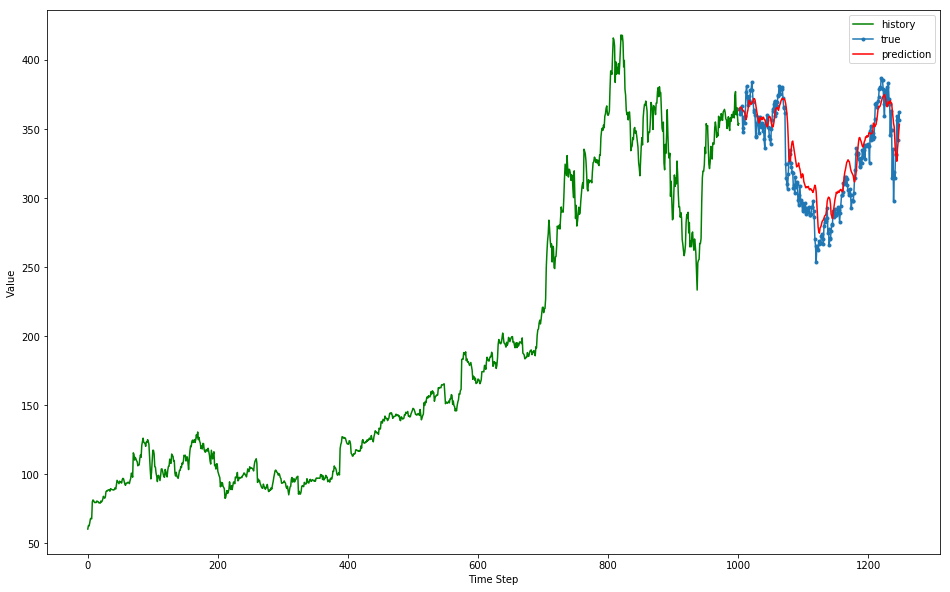

In [84]:
y_pred = model.predict(X_test)
ypred_inv = (y_pred*int(train_std))+int(train_mean)

plt.plot(np.arange(0, len(y_inv)), y_inv, 'g', label="history")
plt.plot(np.arange(len(y_inv), len(y_inv) + len(ytest_inv)), ytest_inv, marker='.', label="true")
plt.plot(np.arange(len(y_inv), len(y_inv) + len(ytest_inv)), ypred_inv, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

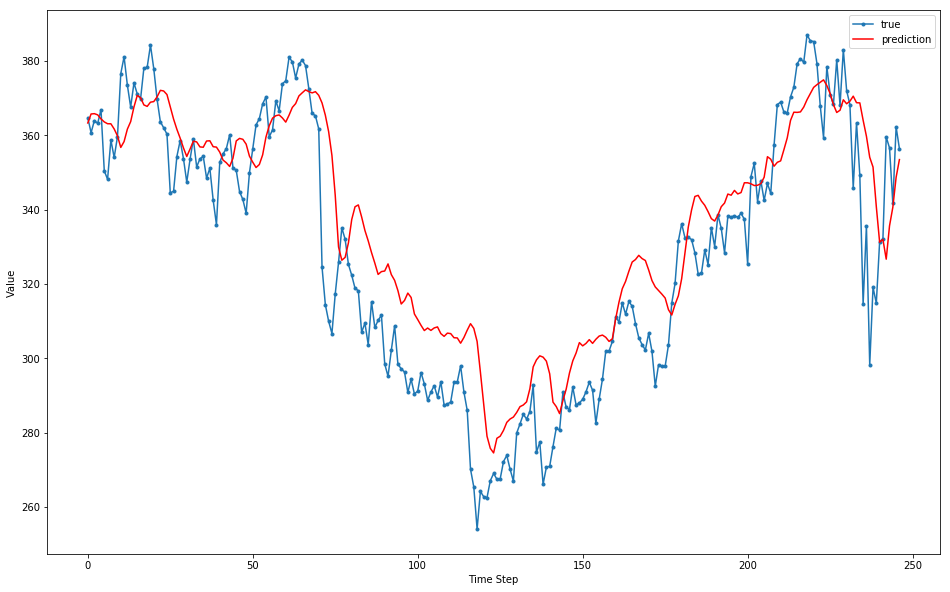

In [85]:
plt.plot(ytest_inv, marker='.', label="true")
plt.plot(ypred_inv, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();